## Loading MNIST dataset.
Loads the MNIST dataset from CSV files

In [1]:
%load_ext lab_black

import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf

import pandas as pd
import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import sys

2022-10-21 09:03:22.945099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 09:03:23.744169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:/usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:
2022-10-21 09:03:23.744196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above

In [2]:
# Loading dataset
train_images = pd.read_parquet("train_images_mnist.parquet", header=None)
train_labels = pd.read_csv("train_labels_mnist.csv", header=None)
test_images = pd.read_csv("test_images_mnist.csv", header=None)

## Class distribution 

<AxesSubplot:xlabel='0'>

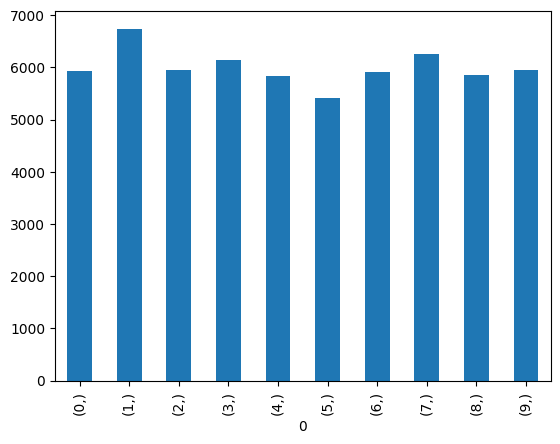

In [3]:
train_labels.value_counts().sort_index().plot.bar()

# Split datasets

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images,
    np.array(train_labels[0].tolist()),
    stratify=np.array(train_labels[0].tolist()),
    test_size=0.30,
    random_state=42,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.50, random_state=42
)

In [5]:
X_train = X_train.values.astype("float32")
X_test = X_test.values.astype("float32")
X_val = X_val.values.astype("float32")

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

In [6]:
y_train_hot = tf.keras.utils.to_categorical(y_train)
y_val_hot = tf.keras.utils.to_categorical(y_val)
y_test_hot = tf.keras.utils.to_categorical(y_test)

# Make sure things ordered

------------ 2 ------------


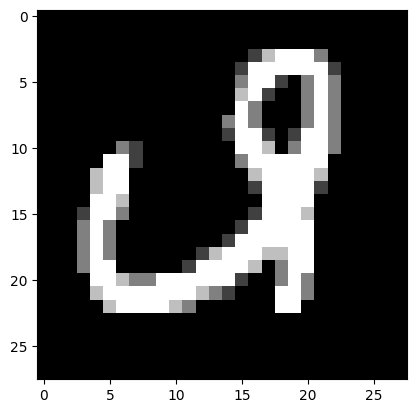

------------ 4 ------------


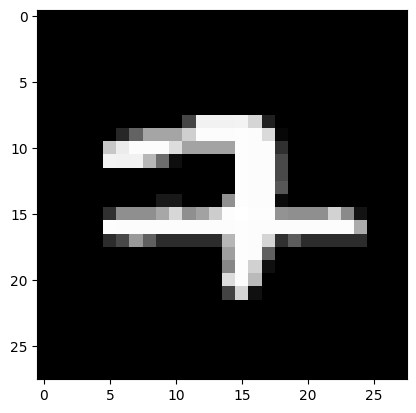

------------ 7 ------------


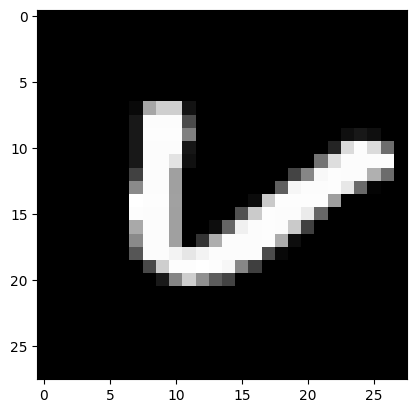

------------ 4 ------------


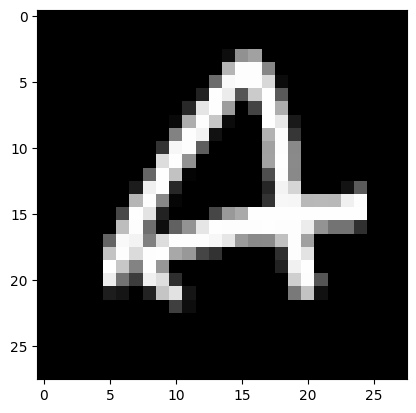

------------ 8 ------------


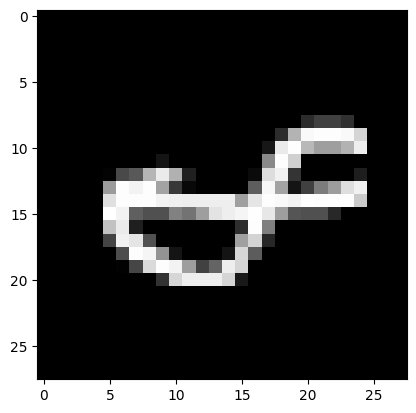

------------ 6 ------------


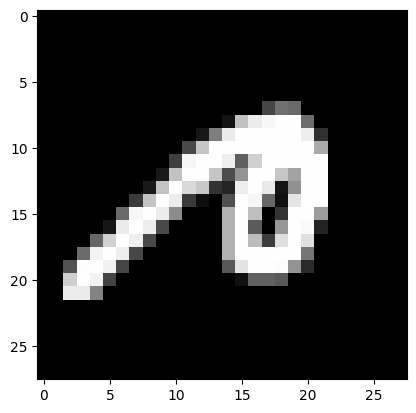

------------ 3 ------------


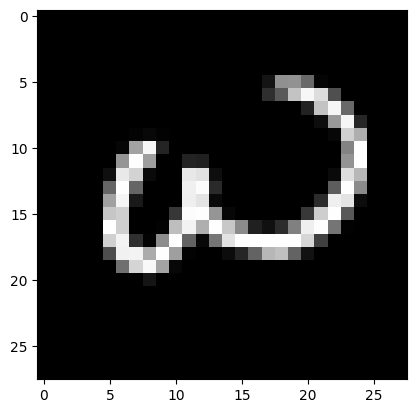

------------ 6 ------------


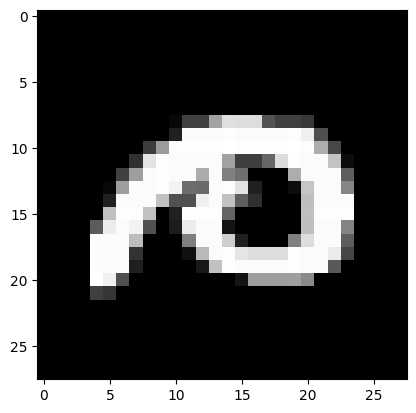

------------ 6 ------------


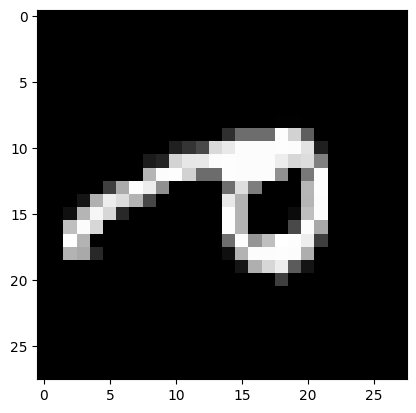

------------ 0 ------------


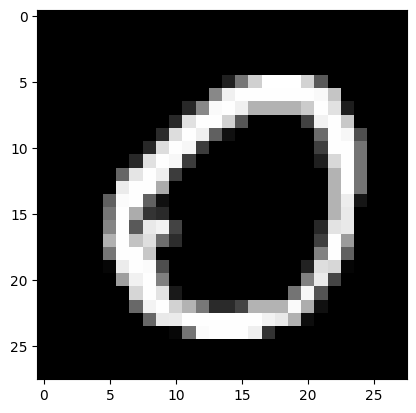

In [7]:
for i in range(10):

    print("------------", y_train[i], "------------")
    plt.imshow(X_train[i].reshape(-1, 28), cmap=plt.get_cmap("gray"))
    plt.show()

# Build Model

In [8]:
def create_embedding_network():

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=2,
                padding="same",
                activation="relu",
                input_shape=(28, 28, 1),
            ),
            tf.keras.layers.MaxPooling2D(pool_size=2),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=2, padding="same", activation="relu"
            ),
            tf.keras.layers.MaxPooling2D(pool_size=2),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                256, activation=None
            ),  # No activation on final dense layer
            tf.keras.layers.Lambda(
                lambda x: tf.math.l2_normalize(x, axis=1)
            ),  # L2 normalize embeddings
        ]
    )
    return model


def create_base_network(triplet_loss_size=256, dense_size=256, label_size=10):

    input_size = tf.keras.layers.Input(shape=(triplet_loss_size,))
    x = tf.keras.layers.Dense(dense_size, activation="relu")(input_size)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(label_size, activation="softmax")(input_size)

    base_network = tf.keras.models.Model(inputs=input_size, outputs=x)

    return base_network

In [9]:
model_base = create_base_network()
model_base.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
)

2022-10-21 09:04:08.948706: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-21 09:04:08.948769: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-10-13-191): /proc/driver/nvidia/version does not exist
2022-10-21 09:04:08.950174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


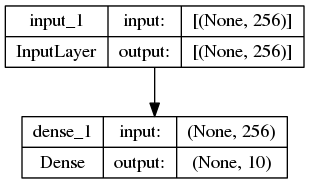

In [15]:
tf.keras.utils.plot_model(
    model_base, to_file="base_network.png", show_shapes=True, show_layer_names=True
)

In [10]:
model_embedding = create_embedding_network()
model_embedding.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss(),
)

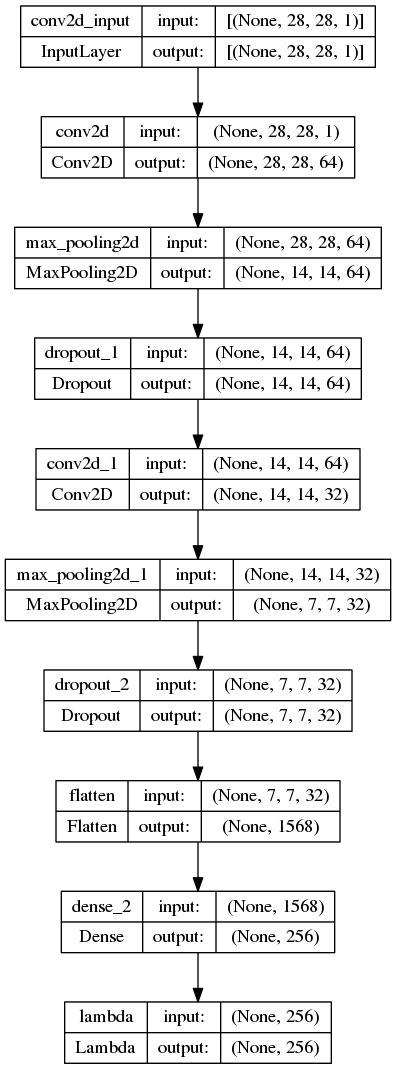

In [14]:
tf.keras.utils.plot_model(
    model_embedding, to_file="base_network.png", show_shapes=True, show_layer_names=True
)

# Train the embedding using Triplet Loss

In [16]:
history = model_embedding.fit(
    X_train, y_train, epochs=5, validation_data=(X_val, y_val)
)

Epoch 1/5
1313/1313 [==============================] - 37s 27ms/step - loss: 0.6388 - val_loss: 0.4258
Epoch 2/5
1313/1313 [==============================] - 35s 26ms/step - loss: 0.4876 - val_loss: 0.3646
Epoch 3/5
1313/1313 [==============================] - 36s 27ms/step - loss: 0.4488 - val_loss: 0.3328
Epoch 4/5
1313/1313 [==============================] - 36s 27ms/step - loss: 0.4263 - val_loss: 0.3126
Epoch 5/5
1313/1313 [==============================] - 35s 27ms/step - loss: 0.4108 - val_loss: 0.3058


In [170]:
X_train_emb = model_embedding.predict(X_train)
X_val_emb = model_embedding.predict(X_val)

282/282 [==============================] - 2s 8ms/step


# Train the classification mnist model

In [173]:
history_2 = model_base.fit(X_train_emb, y_train_hot, epochs=10, validation_data=(X_val_emb, y_val_hot))

Epoch 1/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.4102
Epoch 2/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0946
Epoch 3/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0813
Epoch 4/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0767
Epoch 5/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0745
Epoch 6/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0733
Epoch 7/10
1313/1313 [==============================] - 2s 2ms/step - loss: 0.0724
Epoch 8/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0720
Epoch 9/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0716
Epoch 10/10
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0713


In [174]:
X_test_emb = model_embedding.predict(X_test)
result = model_base.predict(X_test_emb)

282/282 [==============================] - 0s 1ms/step


In [175]:
preds = [x.argmax() for x in result]

# Test set result

In [177]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       888
           1       0.99      0.98      0.99      1011
           2       0.97      0.98      0.97       893
           3       0.98      0.98      0.98       920
           4       0.98      0.98      0.98       877
           5       0.97      0.98      0.97       813
           6       0.98      0.97      0.97       888
           7       0.97      0.98      0.98       940
           8       0.98      0.98      0.98       877
           9       0.98      0.97      0.97       893

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000



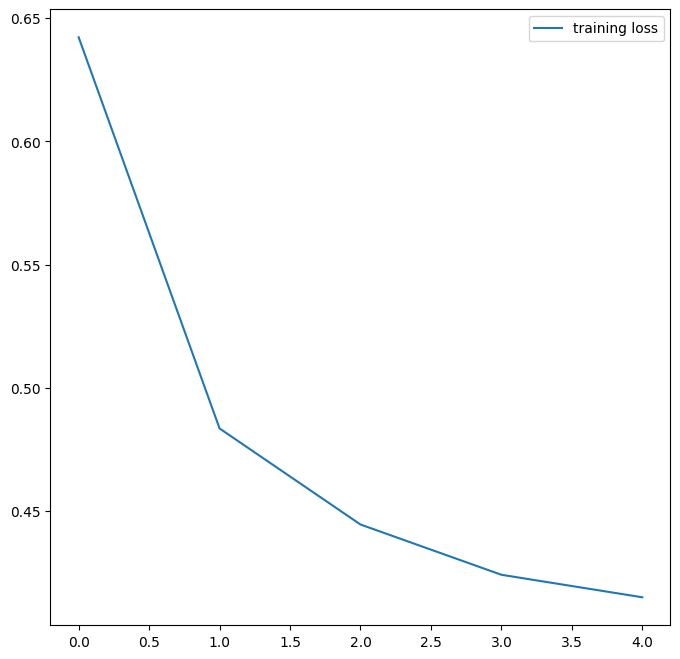

In [178]:
plt.figure(figsize=(8, 8))
plt.plot(history.history["loss"], label="training loss")
plt.legend()
plt.show()

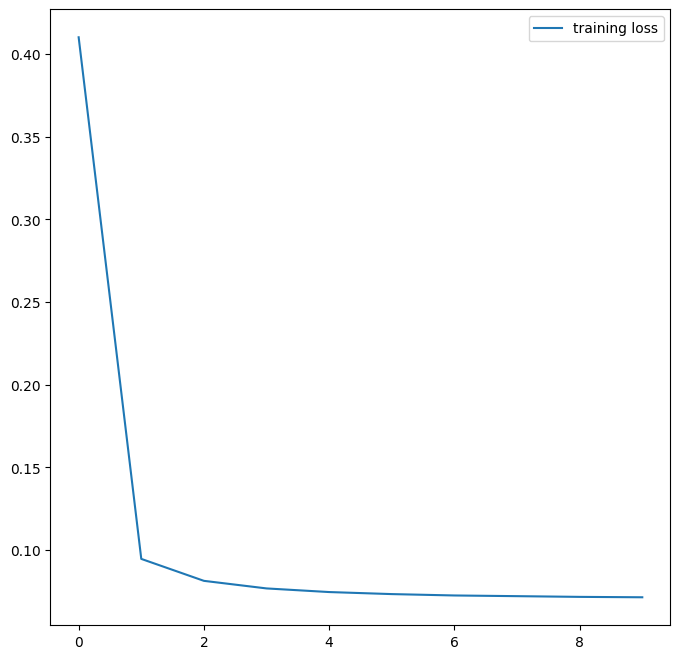

In [179]:
plt.figure(figsize=(8, 8))
plt.plot(history_2.history["loss"], label="training loss")
plt.legend()
plt.show()

# Inferrence

In [19]:
X_infer = test_images.values.astype("float32")
X_infer = X_infer.reshape(-1, 28, 28, 1)

In [20]:
X_infer_emb = model_embedding.predict(X_infer)
infer_result = model_base.predict(X_infer_emb)

313/313 [==============================] - 0s 1ms/step


In [23]:
infer_result = [x.argmax() for x in infer_result]

In [24]:
infer_df = pd.DataFrame()
infer_df["inferred_label"] = infer_result
infer_df.to_csv("test_result.csv", index=False)